# Programming Lenet5 with MindSpore

## 0. Configuring the Running Information

In [1]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target='CPU', enable_mem_reuse=False)

## 1. Downloading and preprocessing the Dataset
### Download the Dataset

In [2]:
import os
import urllib.request
from urllib.parse import urlparse
import gzip

def unzipfile(gzip_path):
    open_file = open(gzip_path.replace('.gz',''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()

def download_dataset():
    train_path = "./MNIST_Data/train/"
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists("./MNIST_Data/train/")
    test_path_check = os.path.exists("./MNIST_Data/test/")
    if train_path_check == False and test_path_check ==False:
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}
    for url in train_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(train_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)
    for url in test_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(test_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)

download_dataset()

### Processing Data

In [3]:
import mindspore.dataset.transforms.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.transforms.vision import Inter
from mindspore.common import dtype as mstype

import mindspore.dataset as ds


def processing_data(data_path, batch_size=32):

    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define operation parameters
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

   # define map operations
    resize_op =      CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # Resize images to (32, 32)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) # normalize images
    rescale_op =     CV.Rescale(rescale, shift) # rescale images
    hwc2chw_op =     CV.HWC2CHW() # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op =   C.TypeCast(mstype.int32) # change data type of label to int32 to fit network

    # apply map operations on images
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op)

    # apply DatasetOps
    mnist_ds = mnist_ds.shuffle(buffer_size=10000)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)

    return mnist_ds

ds_train = processing_data("./MNIST_Data/train", 32)
ds_eval  = processing_data("./MNIST_Data/test")


### Check the dataset

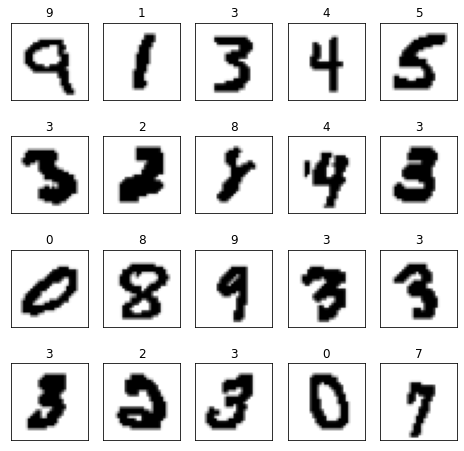

In [4]:
import numpy as np
import matplotlib.pyplot as plt

iterator = ds_train.create_dict_iterator()
item = next (iterator)

image = np.squeeze(item["image"],1)
label = item["label"]
    
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(image[idx,:,:], cmap=plt.cm.binary)
    ax.set_title(str(label[idx]))


## 2. Defining the Model

In [5]:
import mindspore.nn as nn
import mindspore.ops.operations as P

from mindspore.common.initializer import TruncatedNormal

def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, 
                               weight_init=weight_variable(), has_bias=False, 
                               pad_mode="valid"
                              )
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, 
                               weight_init=weight_variable(),has_bias=False, 
                               pad_mode="valid"
                              )
        self.fc1 =  nn.Dense(in_channels= 16 * 5 * 5, out_channels= 120 ,weight_init= weight_variable(),bias_init=weight_variable())
        self.fc2 =  nn.Dense(in_channels= 120,  out_channels= 84,weight_init=weight_variable(),bias_init=weight_variable())
        self.fc3 =  nn.Dense(in_channels=  84, out_channels= 10,weight_init=weight_variable(),bias_init=weight_variable())
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.reshape = P.Reshape()
   
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.reshape(x, (self.batch_size, -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    
network = LeNet5()


## 3. Configuring the learning process

In [6]:
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.nn import Momentum

criterion = SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
optimizer = Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

## 4. Training the Network
### Saving the Configured Model


In [7]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor

epochs = 1


config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)


### Calling the High-level Model API To Train and Save the Model File

In [8]:
from mindspore.nn.metrics import Accuracy

from mindspore.train import Model

model = Model(network, criterion, optimizer, metrics={"Accuracy": Accuracy()})

In [9]:

model.train(epochs, ds_train, callbacks=[ckpoint_cb, LossMonitor()], dataset_sink_mode=False)


epoch: 1 step: 1, loss is 2.3029962
epoch: 1 step: 2, loss is 2.3023033
epoch: 1 step: 3, loss is 2.3042462
epoch: 1 step: 4, loss is 2.3055491
epoch: 1 step: 5, loss is 2.300112
epoch: 1 step: 6, loss is 2.30389
epoch: 1 step: 7, loss is 2.3018756
epoch: 1 step: 8, loss is 2.3052802
epoch: 1 step: 9, loss is 2.3092847
epoch: 1 step: 10, loss is 2.2985802
epoch: 1 step: 11, loss is 2.3039274
epoch: 1 step: 12, loss is 2.3022556
epoch: 1 step: 13, loss is 2.3035452
epoch: 1 step: 14, loss is 2.3043737
epoch: 1 step: 15, loss is 2.3053923
epoch: 1 step: 16, loss is 2.3018212
epoch: 1 step: 17, loss is 2.304602
epoch: 1 step: 18, loss is 2.3022635
epoch: 1 step: 19, loss is 2.3065553
epoch: 1 step: 20, loss is 2.3035917
epoch: 1 step: 21, loss is 2.2996135
epoch: 1 step: 22, loss is 2.3034377
epoch: 1 step: 23, loss is 2.3002315
epoch: 1 step: 24, loss is 2.301465
epoch: 1 step: 25, loss is 2.2971945
epoch: 1 step: 26, loss is 2.2951753
epoch: 1 step: 27, loss is 2.2972674
epoch: 1 step: 

## 5. Model Evaluation

In [10]:
!ls

First_Contact_with_MindSpore_12Apr2020_23_30.ipynb  etc    root
MNIST_Data					    home   run
analyze_fail.dat				    lib    sbin
bin						    lib64  srv
boot						    media  sys
checkpoint_lenet-1_1875.ckpt			    mnt    tmp
checkpoint_lenet-graph.meta			    opt    usr
dev						    proc   var


In [14]:
from mindspore.train.serialization import load_checkpoint, load_param_into_net

# load the saved model for evaluation
param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
# load parameter to the network
load_param_into_net(network, param_dict)
# load testing dataset
acc = model.eval(ds_eval, dataset_sink_mode=False)
print("{}".format(acc))

{'Accuracy': 0.961738782051282}
